In [ ]:
## reference https://huggingface.co/learn/nlp-course/en/chapter7/6?fw=pt#training-a-causal-language-model-from-scratch

In [2]:
#installing some libraries
!pip install datasets
!pip install --upgrade jupyter ipywidgets



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch, transformers
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import PreTrainedModel, PretrainedConfig
from transformers import AutoModel, AutoConfig,AutoModelForCausalLM
from transformers import DataCollatorForLanguageModeling



import torch.nn as nn
import torch.nn.functional as F
#from datasets import load_dataset
import pandas as pd, numpy as np
from torch import cuda
import datetime
import warnings
from torch.optim.lr_scheduler import LambdaLR
# Ignore all warnings
warnings.filterwarnings('ignore')
#pip install transformers bitsandbytes>=0.39.0 -q


In [4]:
#!nvidia-smi

In [5]:
#global params for training

batch_size = 8
epoch = 100
min_text_len = 0
# train_loss_list = []
# val_loss_list =[]
if cuda.is_available():
    device = torch.device('cuda:0')
    print(device)
else:
    device = 'cpu'
#print(device)
import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
#os.environ["MKL_DEBUG_CPU_TYPE"] = "5"
context_length = None
global_tr_loss = torch.inf
global_val_loss = torch.inf
#print(global_tr_loss)
model_path = os.path.join("model")
print(model_path)

cuda:0
model


In [6]:
#loading the dataset as hugging face dataset
from datasets import load_dataset
import pandas as pd, numpy as np

from datasets import load_dataset

dataset =load_dataset('wikitext', 'wikitext-103-raw-v1')


In [7]:
#inspecting the dataset and the split
dataset


DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 1801350
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

In [8]:
#creating pandas dataframe for easy manipulations and analysis
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_val = pd.DataFrame(dataset['validation'])


In [9]:
print(len(df_train))
print(len(df_val))

1801350
3760


In [10]:
df_train.head()

,text
0,
1,= Valkyria Chronicles III = \n
2,
3,Senjō no Valkyria 3 : Unrecorded Chronicles (...
4,"The game began development in 2010 , carrying..."


In [11]:
#let's create a new column called 'length' on our dataframe to analyze the text

df_train['length'] = df_train['text'].apply(lambda x: len(x))
df_val['length'] = df_val['text'].apply(lambda x: len(x))
df_test['length'] = df_test['text'].apply(lambda x: len(x))


In [12]:
df_train.head()

,text,length
0,,0
1,= Valkyria Chronicles III = \n,30
2,,0
3,Senjō no Valkyria 3 : Unrecorded Chronicles (...,706
4,"The game began development in 2010 , carrying...",524


## Analyzing the length of the text

In [13]:
print(f"the range of length in the train set is {max(df_train.length)} down to {min(df_train.length)}")

the range of length in the train set is 7066 down to 0


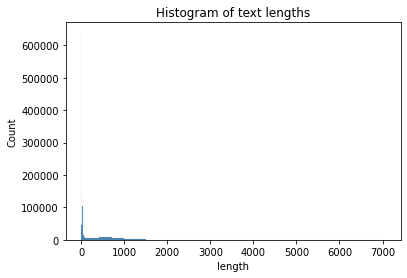

In [14]:
## Lets check the the distributions

sns.histplot(df_train['length'], bins='auto')
plt.title('Histogram of text lengths')
plt.show()


#### we see that majority of the text is between 0 and 2000. Since the maximum length of text the GPT model handles is 1024, let's see that distribution.

In [15]:
import numpy as np


array = np.arange(0, 1024, step=100)
print(array)


[   0  100  200  300  400  500  600  700  800  900 1000]


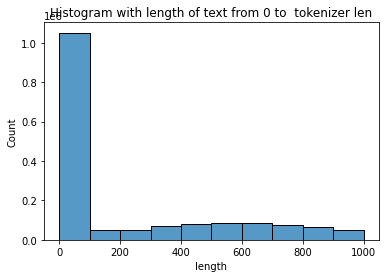

In [16]:
sns.histplot(df_train['length'], bins= array)
plt.title('Histogram with length of text from 0 to  tokenizer len')
plt.show()

In [17]:
# Let us check the number of rows whose length > 1024(the defualt length that the tokenizer can process)
exceed_tok_len = sum(df_train['length']> 1024)/len(df_train)*100
print(f"fewer than {exceed_tok_len}% of rows have text more than the length of tokenizer")

fewer than 7.369361867488272% of rows have text more than the length of tokenizer


In [18]:
#Lets check for the number of rows where length is 0
sum(df_train['length'] == min_text_len)


636321

#### We notice that some of the rows in our dataframe have no text.
Removing such rows and resetting the indices 

In [19]:
df_train = df_train[df_train['length'].astype(bool)]

In [20]:
df_val = df_val[df_val['length'].astype(bool)]

In [21]:
df_test = df_test[df_test['length'].astype(bool)]

In [22]:
sum(df_train['length'] == min_text_len)

0

In [23]:
sum(df_val['length'] == 0)

0

In [24]:
df_train.head()

,text,length
1,= Valkyria Chronicles III = \n,30
3,Senjō no Valkyria 3 : Unrecorded Chronicles (...,706
4,"The game began development in 2010 , carrying...",524
5,"It met with positive sales in Japan , and was...",574
7,= = Gameplay = = \n,19


In [25]:
# resetting the index
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)


In [26]:
#calc the average len of the text:
mean_len = int(df_train.length.mean())
print(mean_len)
import math
power = math.ceil(math.log2(mean_len))
print(power)
context_length = 2**power
context_length

462
9


512

In [27]:
# Test the tokenizer:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2", padding = True ,return_tensors = "pt" , truncate = True, max_length  = context_length ,return_overflowing_tokens=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained("distilgpt2")





In [28]:
# Test code
#define a list of randomly generated text
# x = list(np.random.randint(0,60000,10))
# x
# text_list = [df_train.iloc[x]['text'] for x in x]
# text_list
# outputs = tokenizer(
#     text_list,
#     truncation=True,
#     max_length=context_length,
#     return_overflowing_tokens=True,
#     return_length=True,
#     padding = True
    
# )

# #print(f"Output: {outputs}")
# #print(f"Input IDs : {(outputs['input_ids'])}")
# print(f"Input IDs len : {(outputs['input_ids'])}")
# print(f"Input chunk lengths: {(outputs['length'])}")
# print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

### Data loaders and Dataset for batched training

In [29]:
class dataset_pyt_old(Dataset):
    def __init__(self, df, tokenizer, max_length = context_length ):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        
                        
    def __getitem__(self, idx):
        
        print(f"inside loader...idx ->{idx}")
        text = self.df.iloc[idx]['text']
        print(f"length of text ->{len(text)}")
        print(f"text ->{text}")
        encoded = tokenizer(text, truncation=True, max_length=context_length, return_overflowing_tokens=True, padding = 'max_length')
        input_ids = torch.tensor(encoded['input_ids']).squeeze()
        #print(f"inside the loader and input_id = {input_ids} and its shape is {input_ids.shape}")
        
        attention_mask = torch.tensor(encoded['attention_mask']).squeeze()
#       print(f"inside the loader and input_id = {input_ids} and its shape is {input_ids.shape}")
        labels = input_ids.clone()
        print(f"inside the loader and input_id shape= {input_ids.shape} attention_mask_shape is {attention_mask.shape} and label shape is {labels.shape}")
        return input_ids, attention_mask, labels
        
    def __len__(self):
        #return the length of the dataframe
        return len(self.df)
    

In [30]:
class dataset_pyt(Dataset):
    def __init__(self, df, tokenizer, max_length = context_length ):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
                                
    def __getitem__(self, idx):
        #print(f"inside loader...idx ->{idx}")
        text = self.df.iloc[idx]['text']
        #print(f"length of text ->{len(text)}")
        #print(f"text ->{text}")
        encodings = tokenizer(text, truncation=True, max_length= self.max_length, return_overflowing_tokens=True, padding = 'max_length',return_tensors='pt')
        # check the length of the encoded list
        
        #x_dict['input_id'] = input_ids_list
        #x_dict['attention_mask'] = input_ids_list
                
        #print(f"x_dict = {x_dict}")             
#       print(f"inside the loader and input_id = {input_ids} and its shape is {input_ids.shape}")
        #labels = input_id_list
        #input_ids = torch.tensor(input_id_list)
        #attention_mask = torch.tensor(attention_mask_list)
        #labels = torch.tensor(labels)
        #print(f"inside the loader and input_id shape= {input_ids.shape} attention_mask_shape is {attention_mask.shape} and label shape is {labels.shape}")
        #print(f"encoding = {encodings}")
               
        return encodings
        
    def __len__(self):
        #return the length of the dataframe
        return len(self.df)

In [31]:
def custom_collate_fn(batch):
    x_dict = {}
    #print("CUSTOM COllate")
    #print(f"bacth = {batch}")
    input_ids_list = []
    att_mask_list = [] 
    for item in batch:
        input_ids_list.append(item['input_ids'])
        att_mask_list.append(item['attention_mask'])
    #attention_mask = [item['attention_mask'].squeeze(0) for item in batch]

    # Pad sequences to the same length
    #print(f"len of input_id_list = {len(input_ids_list)}")
    #print(f"len of attmask_list = {len(att_mask_list)}")
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids_list, batch_first=True, padding_value=tokenizer.eos_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(att_mask_list, batch_first=True, padding_value=0)
    #print(f"shape of input_id tensor post padding -{input_ids.shape}")
    #print(f"shape of attention_masks tensor post padding -{attention_mask.shape}")
    x_dict['input_ids'] = input_ids
    x_dict['attention_mask'] = attention_mask
    
    return x_dict

In [32]:
train_dataset = dataset_pyt(df_train,tokenizer = tokenizer)
val_dataset = dataset_pyt(df_val,tokenizer = tokenizer)
test_dataset = dataset_pyt(df_test,tokenizer = tokenizer)

train_loader = DataLoader(train_dataset,batch_size = batch_size, shuffle = True , num_workers = 0, pin_memory = False, collate_fn = custom_collate_fn)
val_loader = DataLoader(val_dataset,batch_size = batch_size, shuffle = True , collate_fn = custom_collate_fn)
test_loader = DataLoader(test_dataset,batch_size = batch_size, shuffle = False, collate_fn = custom_collate_fn)

    

### Training the model

In [33]:
#https://stackoverflow.com/questions/73948214/how-to-convert-a-pytorch-nn-module-into-a-huggingface-pretrainedmodel-object/74109727#74109727
# this code is needed to save the HF model as pre-trained and use this model as inference
# class MyConfig(PretrainedConfig):
#     model_type = 'mymodel'
#     def __init__(self, important_param=42, **kwargs):
#         super().__init__(**kwargs)
#         self.important_param = important_param

# class MyModel(PreTrainedModel):
#     config_class = MyConfig
#     def __init__(self, config):
#         super().__init__(config)
#         self.config = config
#         self.model = clf_model_drp()
#     def forward(self, ids ,token_type,att_mask):
#         return self.model(ids ,token_type,att_mask) 

In [34]:
@torch.no_grad
def eval_model(val_loader, model, epoch , device = device,):
    global global_val_loss
    #m = nn.Softmax()
    model.eval()
    model.to(device)
    e = epoch+1
    val_loss_list = []
    #criterion = torch.nn.BCEWithLogitsLoss()
    print(f"inside validation data for epoch {e}")
    #y_hat_val_list = []
    #y_val_list = []
    
    for ind,x_dict in enumerate in enumerate(val_loader):
        id_list = x_dict['input_ids']
        #print(f"id_list{id_list}")
        ids = id_list.clone().detach().to(device = device)
        att_list = x_dict['attention_mask']
        att_mask = att_list.clone().detach().to(device= device)
        labels = ids.clone().detach().to(device = device)
        #predictions
        #print(f"input_ids device = {input_ids.device}")
        model_output = model(input_ids = ids ,attention_mask = att_mask, labels = labels)
            
    mean_val_loss = torch.mean(torch.tensor(val_loss_list))
    if mean_val_loss < global_val_loss:
        print(f"Val loss has decreased -->reducing the global validation loss from {global_val_loss:.2f} to {mean_val_loss:.2f}")
        global_val_loss = mean_val_loss
        print(f" validation loss for epoch = {e} is {torch.mean(torch.tensor(val_loss_list)):.4f}")
        #print metrics and save the model
        #y_hat_val = torch.cat(y_hat_val_list)
        #y_val = torch.cat(y_val_list)
        #acc_val = accuracy_score(y_val.cpu().numpy(), y_hat_val.cpu().numpy())
        #f1_val = f1_score(y_val.cpu().numpy(), y_hat_val.cpu().numpy(), average='micro')
        print(f" epoch= {e} : mean val loss is {torch.mean(torch.tensor(mean_val_loss)):.4f} ")
        #save the model
        
        # Get the current date and time
        current_datetime = datetime.datetime.now()
        # Extract date and time components
        current_date = str(current_datetime.date())
        current_time = str(current_datetime.time()).split('.')[0]
        file_name = 'model'+ current_date+current_time+'_'+'.pth'
        path = os.path.join("model",file_name)
        print(f"saving the model {file_name}")
        #torch.save(model.state_dict(), path)
        model.save_pretrained(path)
        
        #plot_confusion_matrix(y_val.cpu().numpy(), y_hat_val.cpu().numpy(), labels)
    else:
        print(f"No improvement in validation loss-->epoch= {e} and global val loss is {global_val_loss:.2f}")
        
    
    
    
      

In [35]:
def train_model(train_loader,val_loader,model,num_epoch = 5,device = device):
    global global_tr_loss
    model.train()
    device = device
    print(f"inside train model. Device = {device}")
    optimizer = torch.optim.AdamW(params =  model.parameters(), lr= 5e-5)
    model.to(device)
    #m = nn.Softmax()
    from transformers import get_linear_schedule_with_warmup
    scheduler = transformers.get_cosine_schedule_with_warmup( optimizer= optimizer, num_warmup_steps =len(train_loader)*num_epoch*.1 ,num_training_steps= len(train_loader)*num_epoch,last_epoch = -1 )
    
    for i in range (num_epoch):
        #y_hat_list =[]
        #label_list = []
        epoch_train_loss = []
        for ind,x_dict in enumerate(train_loader):
            #print(f"x_dict = {x_dict}")
            id_list = x_dict['input_ids']
            #print(f"id_list{id_list}")
            ids = id_list.clone().detach().to(device = device)
            att_list = x_dict['attention_mask']
            att_mask = att_list.clone().detach().to(device= device)
            labels = ids.clone().detach().to(device = device)
            #predictions
            #print(f"input_ids device = {input_ids.device}")
            model_output = model(input_ids = ids ,attention_mask = att_mask, labels = labels)
            #print(f"model_output->{model_output}")
            #probs = m(logits)
            #y_hat_list.append(torch.argmax(probs , dim = 1))
            #label_list.append(torch.argmax(lab, dim = 1))
            
            #loss calculation                   
            act_loss = model_output.loss
            epoch_train_loss.append(act_loss)
            #epoch_train_loss.append(act_loss.item())
            optimizer.zero_grad(set_to_none=True)
            act_loss.backward()
            optimizer.step()
            #print(f"current LR->{scheduler.get_last_lr()}")
            scheduler.step()
            #print(f"POST SCHEDULER.step LR->{scheduler.get_last_lr()}")
            
        #batch processing complete    
        mean_loss = torch.mean(torch.tensor(epoch_train_loss))
        
        if mean_loss < global_tr_loss:
            print(f"training loss has decreased---> reducing the global loss from {global_tr_loss:.2f} to {mean_loss:.2f}")
            global_tr_loss = mean_loss
            print(f" epoch= {i+1} and mean train loss is {torch.mean(torch.tensor(epoch_train_loss)):.2f}")
            #printing training metrices
            #y_hat = torch.cat(y_hat_list)
            #y = torch.cat(label_list)
            #acc = accuracy_score(y.cpu().numpy(), y_hat.cpu().numpy())
            #f1 = f1_score(y.cpu().numpy(), y_hat.cpu().numpy(), average='micro')
            print(f" epoch= {i+1} : mean train loss is {torch.mean(torch.tensor(epoch_train_loss)):.4f} ")
            #checking validation metrices
            eval_model(val_loader, model, epoch = i , device = device)
            
        else:
            print(f"No improvement in training loss..the global training loss is -->{global_tr_loss:.2f} ")
            print(f" epoch= {i+1} and mean train loss is {torch.mean(torch.tensor(epoch_train_loss)):.2f}")
        
        
    
    return model
        
            
            
    
    

In [ ]:
# config = MyConfig(42)
# model = MyModel(config)

#train_loader,optimizer,val_loader ,num_epoch = 100, model = clf_model()
tr_model = train_model(train_loader, val_loader, model =  model)

inside train model. Device = cuda:0


### Evaluating the models on test data

In [ ]:
def tokenize(element):
    outputs = tokenizer(
        element["content"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}


tokenized_datasets = raw_datasets.map(
    tokenize, batched=True, remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets

In [ ]:
t = df_train.iloc[400327]['text']
print (t)
print(len(t))
encoded = tokenizer(t, truncation=True, max_length=context_length, return_overflowing_tokens=True, padding = 'max_length',return_length= True)
print(encoded)
input_ids = torch.tensor(encoded['input_ids'])
print(f"inside the loader and input_id = {input_ids} and its shape is {input_ids.shape}")

attention_mask = torch.tensor(encoded['attention_mask'])
#       print(f"inside the loader and input_id = {input_ids} and its shape is {input_ids.shape}")
labels = input_ids.clone()
print(f"inside the loader and input_id shape= {input_ids.shape} attention_mask_shape is {attention_mask.shape} and label shape is {labels.shape}")


In [ ]:
def final_pred(loader, model, device = device,):
    m = nn.Softmax()
    model.eval()
    model.to(device)
    test_loss_list = []
    criterion = torch.nn.BCEWithLogitsLoss()
    y_hat_test_list = []
    y_test_list = []
    for ind,(x_dict, label_vec) in enumerate(loader):
        model.to(device)
        id_list = x_dict['id']
        ids = torch.squeeze(torch.tensor(id_list, device = device),dim = 1).clone().detach()
        tok_type_list = x_dict['token_type']
        token_type = torch.squeeze(torch.tensor(tok_type_list, device = device),dim = 1).clone().detach()
        att_list = x_dict['attention_mask']
        att_mask = torch.squeeze(torch.tensor(att_list, device = device),dim = 1).clone().detach()
        lab = label_vec.to(torch.device('cuda:0'))
        logits = model(ids ,token_type,att_mask)
        
        probs = m(logits)
        y_hat_test_list.append(torch.argmax(probs , dim = 1))
        y_test_list.append(torch.argmax(lab , dim = 1))
        
        act_loss = criterion(logits, lab)
        test_loss_list.append(act_loss.item())
            
    mean_test_loss = torch.mean(torch.tensor(test_loss_list))
    print(f" Test loss is {torch.mean(torch.tensor(test_loss_list)):.4f}")
    #print metrics and save the model
    y_hat_test = torch.cat(y_hat_test_list)
    y_test = torch.cat(y_test_list)
    acc_test = accuracy_score(y_test.cpu().numpy(), y_hat_test.cpu().numpy())
    f1_test = f1_score(y_test.cpu().numpy(), y_hat_test.cpu().numpy(), average='micro')
    print(f"mean loss is {torch.mean(torch.tensor(mean_test_loss)):.4f} -> the accuracy is {acc_test:.2f} ->the f1 is {f1_test:.2f} ")
    #save the model
    plot_confusion_matrix(y_test.cpu().numpy(), y_hat_test.cpu().numpy(), labels)

   
        


In [ ]:
saved_model = MyModel.from_pretrained('./model/model2024-05-1712:14:28_mrpc.pth')


In [ ]:
final_pred(test_loader , saved_model )